SRC
1. https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a

In this article, CNN is created using only NumPy library. Just three layers are created which are convolution (conv for short), ReLU, and max pooling. The major steps involved are as follows:
1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking conv, ReLU, and max pooling layers.

In [3]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [1]:
import skimage.data
# Reading the image
img = skimage.data.chelsea()
# Converting the image into gray.
img = skimage.color.rgb2gray(img)

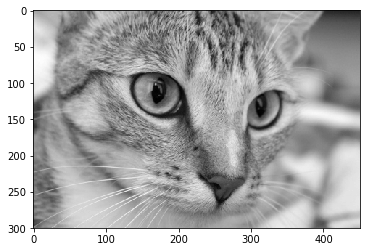

In [10]:
plt.imshow(img,cmap='gray')

## 2. Preparing filters

In [11]:
l1_filter = numpy.zeros((2,3,3))
l1_filter

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [12]:
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = numpy.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])

In [13]:
l1_filter

array([[[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]],

       [[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]]])

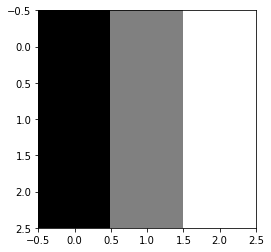

In [65]:
plt.imshow(l1_filter[0,:,:],cmap="gray")

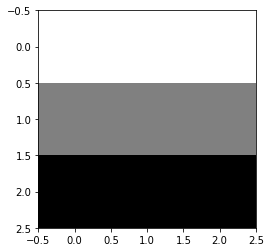

In [66]:
plt.imshow(l1_filter[1,:,:],cmap="gray")

## 3. Conv Layer

In [17]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = numpy.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in numpy.uint16(numpy.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in numpy.uint16(numpy.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-numpy.uint16(numpy.floor(filter_size/2.0)):r+numpy.uint16(numpy.ceil(filter_size/2.0)), 
                              c-numpy.uint16(numpy.floor(filter_size/2.0)):c+numpy.uint16(numpy.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[numpy.uint16(filter_size/2.0):result.shape[0]-numpy.uint16(filter_size/2.0), 
                          numpy.uint16(filter_size/2.0):result.shape[1]-numpy.uint16(filter_size/2.0)]
    return final_result

In [18]:
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

In [83]:
l1_feature_map = conv(img, l1_filter)

Filter  1
Filter  2


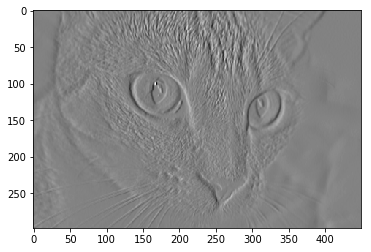

In [84]:
plt.imshow(l1_feature_map[:,:,0],cmap='gray')

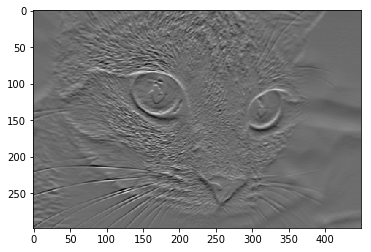

In [85]:
plt.imshow(l1_feature_map[:,:,1],cmap='gray')

## 4. ReLU Layer

In [86]:
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0,feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max([feature_map[r, c, map_num], 0])
    return relu_out

In [87]:
l1_feature_map_relu = relu(l1_feature_map)

It is very simple. Just loop though each element in the feature map and return the original value in the feature map if it is larger than 0. Otherwise, return 0. The outputs of the ReLU layer are shown in figure 3.

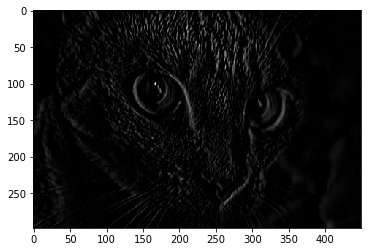

In [88]:
plt.imshow(l1_feature_map_relu[:,:,0],cmap='gray')

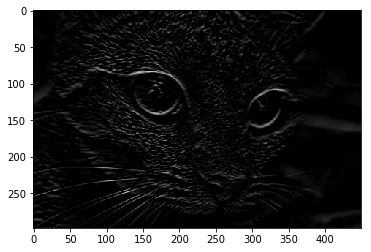

In [89]:
plt.imshow(l1_feature_map_relu[:,:,1],cmap='gray')

Text(0.5, 1.0, 'L1-Map2')

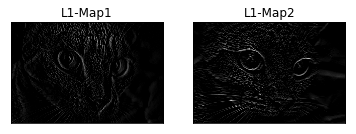

In [90]:
fig1, ax1 = matplotlib.pyplot.subplots(nrows=1, ncols=2)
ax1[0].imshow(l1_feature_map_relu[:,:,0]).set_cmap("gray")
ax1[0].get_xaxis().set_ticks([])
ax1[0].get_yaxis().set_ticks([])
ax1[0].set_title("L1-Map1")

ax1[1].imshow(l1_feature_map_relu[:,:,1]).set_cmap("gray")
ax1[1].get_xaxis().set_ticks([])
ax1[1].get_yaxis().set_ticks([])
ax1[1].set_title("L1-Map2")

## 5. Max Pooling Layer

In [91]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),
                            numpy.uint16((feature_map.shape[1]-size+1)/stride),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):
                pool_out[r2, c2, map_num] = numpy.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

In [92]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

## 6. Stacking Layers
Up to this point, the CNN architecture with conv, ReLU, and max pooling layers is complete. There might be some other layers to be stacked in addition to the previous ones as below.

In [93]:
# Second conv layer
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



In [96]:
l2_feature_map_relu_pool.shape

(71, 109, 3)

Text(0.5, 1.0, 'L1-Map3')

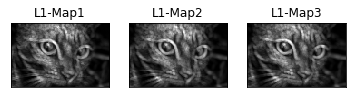

In [98]:
fig1, ax1 = matplotlib.pyplot.subplots(nrows=1, ncols=3,)
ax1[0].imshow(l2_feature_map_relu_pool[:,:,0]).set_cmap("gray")
ax1[0].get_xaxis().set_ticks([])
ax1[0].get_yaxis().set_ticks([])
ax1[0].set_title("L1-Map1")

ax1[1].imshow(l2_feature_map_relu_pool[:,:,1]).set_cmap("gray")
ax1[1].get_xaxis().set_ticks([])
ax1[1].get_yaxis().set_ticks([])
ax1[1].set_title("L1-Map2")

ax1[2].imshow(l2_feature_map_relu_pool[:,:,2]).set_cmap("gray")
ax1[2].get_xaxis().set_ticks([])
ax1[2].get_yaxis().set_ticks([])
ax1[2].set_title("L1-Map3")

In [100]:
# Third conv layer
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 3**")
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")
l3_feature_map_relu = relu(l3_feature_map)
print("\n**Pooling**")
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



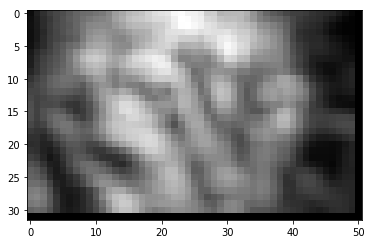

In [103]:
plt.imshow(l3_feature_map_relu_pool[:,:,0],cmap="gray")